In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [2]:
pID = '6'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 0.1s
data_eeg_name_01 = '\data_s6_rp-win_-0.1-0_srate-250_modality-eeg.csv'
data_emg_name_01 = '\data_s6_rp-win_-0.1-0_srate-250_modality-emg.csv'
data_eye_name_01 = '\data_s6_rp-win_-0.1-0_srate-250_modality-eye.csv'

data_eeg_01 = pd.read_csv(path+pID+data_eeg_name_01)
data_remg_01 = pd.read_csv(path+pID+data_emg_name_01)
data_emg_01 = pd.concat([data_remg_01.iloc[:,:4], data_remg_01.iloc[:,4] + 0.270], axis=1)
data_emg_01.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_01 = pd.read_csv(path+pID+data_eye_name_01)

# 1s
data_eeg_name_1 = '\data_s6_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s6_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s6_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)
data_remg_1 = pd.read_csv(path+pID+data_emg_name_1)
data_emg_1 = pd.concat([data_remg_1.iloc[:,:4], data_remg_1.iloc[:,4] + 0.270], axis=1)
data_emg_1.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_1 = pd.read_csv(path+pID+data_eye_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1
data_emg = data_emg_1
data_eye = data_eye_1

# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg))//win_eeg

# EMG Window 
win_emg = 250
win_emg_scaled = np.arange(len(data_emg))//win_emg

# EYE Window 
win_eye = 100
win_eye_scaled = np.arange(len(data_eye))//win_eye

In [3]:
from scipy.stats import wilcoxon
fs=250
#Find the RP treshold
data_wilk_x = data_eeg.iloc[:len(data_eeg)//2,:]
data_wilk_y = data_eeg.iloc[(len(data_eeg)//2):,:]

wilk_x = np.zeros((fs, len(data_wilk_x)//250))
wilk_y = np.zeros((fs, len(data_wilk_x)//250))

for j in range(fs):
    for i in range(wilk_x.shape[1]):
        wilk_x[j, i] = data_wilk_x['P2'].values[(i*250)+j]
        wilk_y[j, i] = data_wilk_y['P2'].values[(i*250)+j]
        
thresh = 0
t_ind_eeg = []
for i in range(1,fs):
    w, p = wilcoxon(wilk_x[i, :], wilk_y[i, :])
    
    if p < 0.05:
        thresh += 1
    else:
        thresh = 0
    if thresh > 3:
        t_ind_eeg.append(i)

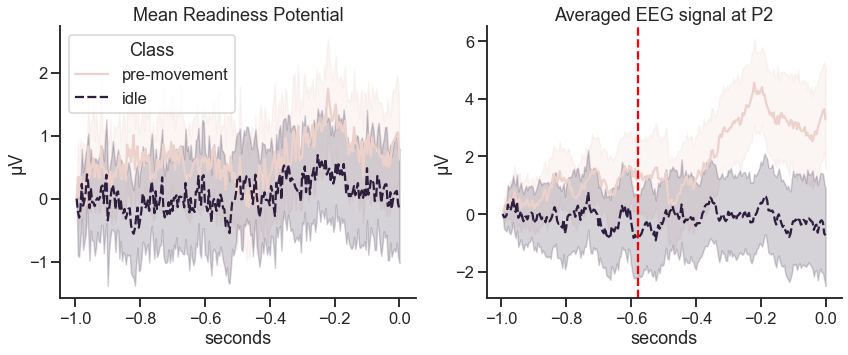

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrodes = data_eeg.iloc[:,3:].mean(axis=1)
electrode = 'P2'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=data_eeg)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data_eeg, legend=False)
g2.set(xlabel='seconds', ylabel='\u03bcV', title='Averaged EEG signal at '+electrode)


# Detection onset
plt.axvline(data_eeg['sample'].values[min(t_ind_eeg)],
            color='red', label = None, linestyle ='--')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

In [6]:
data_eeg['sample'].values[min(t_ind_eeg)]

-0.58

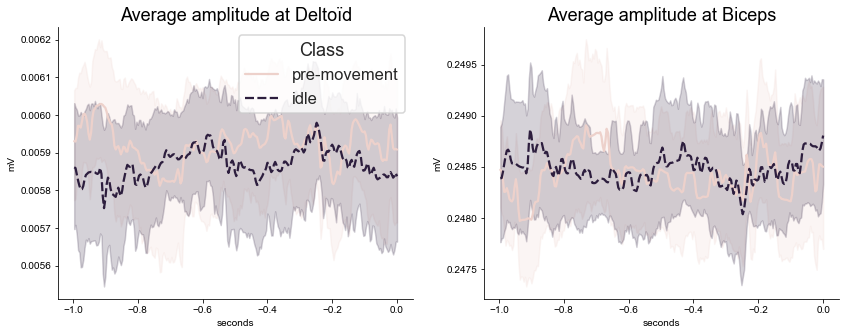

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")


electrode1 = 'Deltoïd'
electrode2 = 'Biceps'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrode1,
             hue="rp_class", style="rp_class",
             data=data_emg)
sns.despine()
g.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode1)

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode2,
             hue="rp_class", style="rp_class",
             data=data_emg, legend=False)
g2.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode2)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

In [13]:
#EEG 1st DataFrame
win_eeg_mean = data_eeg.groupby(win_eeg_scaled).mean() 

df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)

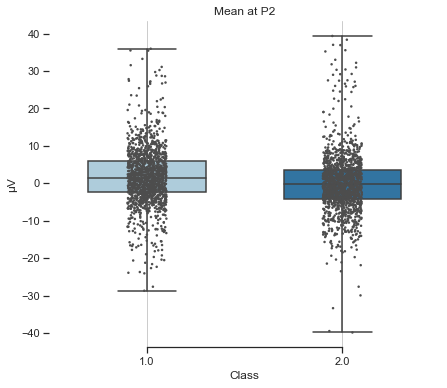

In [15]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = 'rp_class'
val_var = 'P2'

F1 = sns.boxplot(x=group_var, y=val_var, data=win_eeg_mean,
              whis=[0, 100], width=.6, palette='Paired')
F1.set(title='Mean at '+ val_var)

    # Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=win_eeg_mean,
              size=2.5, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='\u03bcV', xlabel='Class')
sns.despine(trim=True, left=True)

In [16]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.6448275862068966
0.0598253502513706


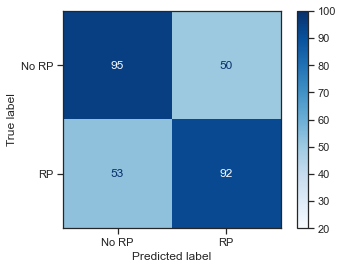

              precision    recall  f1-score   support

       No RP       0.64      0.66      0.65       145
          RP       0.65      0.63      0.64       145

    accuracy                           0.64       290
   macro avg       0.64      0.64      0.64       290
weighted avg       0.64      0.64      0.64       290



In [17]:
cm_eeg = confusion_matrix(y_true=yeeg, y_pred=pred_y_eeg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=yeeg, 
                                y_pred=pred_y_eeg, 
                                target_names=["No RP", "RP"]))

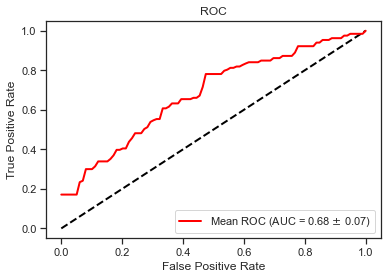

In [18]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xeeg,yeeg):
    prediction = clf_eeg.fit(Xeeg[train],yeeg[train]).predict_proba(Xeeg[test])
    fpr, tpr, t = roc_curve(yeeg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()